RAG（Retrieval-Augmented Generation）在语言模型应用中已经相当成熟，但传统实现往往只是简单的"检索-生成"流程。实际对话场景要复杂得多——用户的问题可能含糊不清，或者会频繁追问，还经常提些不相关的内容。

这篇文章会展示怎么用 LangGraph 构建一个具备实用价值的 RAG 系统，包括能够处理后续追问、过滤无关请求、评估检索结果的质量，同时保持完整的对话记忆。

传统 RAG 就是检索 top-k 文档然后喂给模型生成答案。但对话场景下会遇到几个棘手的问题：用户问题经常模糊不清或者是追问；检索到的 k 个文档可能压根不相关；还有些问题完全不在系统能回答的范围内。

这个问题的解决办法是把聊天历史、文档相关性评分、查询迭代优化以及智能路由结合起来，让系统能够理解上下文，还能自我修正。

最终要实现的系统能做下面的事情：

接收对话式提问包括各种追问，把问题改写成独立完整的形式，判断问题是否属于可回答的范畴，检索相关文档并评估质量，没找到合适文档时自动优化查询重新检索，达到尝试上限后要么给出答案要么返回无法回答，整个过程保留完整对话历史。

In [1]:
!pip install langchain langgraph langchain-openai mypy pillow chromadb langchain_community

In [2]:
# 输入环境 API Key
import os
import getpass

os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key:')

OpenAI API Key:··········


准备测试数据，这里用几个关于餐厅的文档做演示：

In [3]:
from langchain.schema import Document
docs = [
    Document(
        page_content=(
            "Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience "
            "in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community."
        ),
        metadata={"source": "owner.txt"},
    ),
    Document(
        page_content=(
            "Bella Vista offers a range of dishes with prices that cater to various budgets. "
            "Appetizers start at $8, main courses range from $15 to $35, and desserts are priced between $6 and $12."
        ),
        metadata={"source": "dishes.txt"},
    ),
    Document(
        page_content=(
            "Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 AM to 10:00 PM, "
            "while weekend hours are extended from 11:00 AM to 11:00 PM."
        ),
        metadata={"source": "restaurant_info.txt"},
    ),
    Document(
        page_content=(
            "Bella Vista offers a variety of menus including a lunch menu, dinner menu, and a special weekend brunch menu. "
            "The lunch menu features light Italian fare, the dinner menu offers a more extensive selection of traditional and contemporary dishes, "
            "and the brunch menu includes both classic breakfast items and Italian specialties."
        ),
        metadata={"source": "restaurant_info.txt"},
    ),
]

把文档编码后存到 Chroma 向量库里。用 OpenAI 的 embedding 模型，设置返回最相关的 2 个文档：

In [4]:
from langchain_community.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings()
db = Chroma.from_documents(docs, embedding_function)
retriever = db.as_retriever(search_kwargs={"k": 2})

/tmp/ipython-input-115566317.py:4: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding_function = OpenAIEmbeddings()


测试下检索功能：

In [5]:
retriever.invoke("who is the owner of bella vista?")

[Document(metadata={'source': 'owner.txt'}, page_content='Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.'),
 Document(metadata={'source': 'restaurant_info.txt'}, page_content='Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 AM to 10:00 PM, while weekend hours are extended from 11:00 AM to 11:00 PM.')]

输出应该包含老板 Antonio Rossi 的信息。

Prompt 和 RAG 链需要定义一个带历史记录的提示模板，这样模型能理解上下文：

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


template = """
Answer the question based on the following context and the chat history:

Chat history: {history}
Context: {context}
Question: {question}

"""

prompt = ChatPromptTemplate.from_template(template)
llm = chat = ChatOpenAI(model_name="gpt-4o", temperature=0.3)
rag_chain = prompt | llm

状态定义使用DialogState 来追踪整个对话过程中的各种信息：

In [7]:
from typing import List, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

class DialogState(TypedDict):
    turns: List[BaseMessage]
    retrieved_docs: List[Document]
    topic_flag: str
    refined_query: str
    ready_for_response: bool
    refinement_attempts: int
    question: HumanMessage  # <== ✅ This is the correct key to use

整个系统由多个节点组成，每个节点负责一个特定功能。

问题重写器 把追问改写成完整问题。分类器 判断问题是否在回答范围内。路由器 根据分类结果决定走哪条路径。检索器 拉取相关文档。评分器 用 LLM 判断文档是否真的相关。优化器 在没找到合适文档时改写问题重试。生成器 基于检索到的文档和历史对话生成回答。兜底节点 处理超出范围或无法回答的情况。

完整代码如下：

In [8]:
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain.schema import Document
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END

class TopicGrade(BaseModel):
    score: str = Field(
        description="Is the question about the target topics? If yes -> 'Yes'; if not -> 'No'"
    )

def rephrase_query(state: DialogState):
    print(f"Entering rephrase_query with state: {state}")

    # Reset derived fields
    state["retrieved_docs"] = []
    state["topic_flag"] = ""
    state["refined_query"] = ""
    state["ready_for_response"] = False
    state["refinement_attempts"] = 0

    if "turns" not in state or state["turns"] is None:
        state["turns"] = []

    # ✅ Fix: correctly use 'question' key instead of 'user_input'
    if state["question"] not in state["turns"]:
        state["turns"].append(state["question"])

    if len(state["turns"]) > 1:
        chat_history = state["turns"][:-1]
        question_text = state["question"].content
        prompt_msgs = [
            SystemMessage(
                content="You are a helpful assistant that rephrases the user's question to be a standalone question optimized for retrieval."
            )
        ]
        prompt_msgs.extend(chat_history)
        prompt_msgs.append(HumanMessage(content=question_text))

        prompt = ChatPromptTemplate.from_messages(prompt_msgs).format()
        response = llm.invoke(prompt)
        refined = response.content.strip()
        print(f"rephrase_query: Rephrased to: {refined}")
        state["refined_query"] = refined
    else:
        state["refined_query"] = state["question"].content

    return state

def classify_topic(state: DialogState):
    print("Entering classify_topic")
    sys_msg = SystemMessage(
        content="""You are a classifier that determines whether a user's question is about one of the following topics:

1. Information about the owner of Bella Vista, which is Antonio Rossi.
2. Prices of dishes at Bella Vista (restaurant).
3. Opening hours of Bella Vista (restaurant).

If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'."""
    )

    user_msg = HumanMessage(content=f"User question: {state['refined_query']}")
    prompt = ChatPromptTemplate.from_messages([sys_msg, user_msg])
    structured_llm = llm.with_structured_output(TopicGrade)
    grader = prompt | structured_llm
    result = grader.invoke({})
    state["topic_flag"] = result.score.strip()
    print(f"classify_topic: topic_flag = {state['topic_flag']}")
    return state

def topic_router(state: DialogState):
    print("Entering topic_router")
    if state.get("topic_flag", "").strip().lower() == "yes":
        print("Routing to fetch_docs")
        return "fetch_docs"
    else:
        print("Routing to reject_off_topic")
        return "reject_off_topic"

def fetch_docs(state: DialogState):
    print("Entering fetch_docs")
    docs = retriever.invoke(state["refined_query"])
    print(f"fetch_docs: Retrieved {len(docs)} documents")
    state["retrieved_docs"] = docs
    return state

class RelevanceGrade(BaseModel):
    score: str = Field(
        description="Is the document relevant to the user's question? If yes -> 'Yes'; if not -> 'No'"
    )

def evaluate_docs(state: DialogState):
    print("Entering evaluate_docs")
    sys_msg = SystemMessage(
        content="""You are a grader assessing the relevance of a retrieved document to a user question.
Only answer with 'Yes' or 'No'.

If the document contains information relevant to the user's question, respond with 'Yes'.
Otherwise, respond with 'No'."""
    )

    structured_llm = llm.with_structured_output(RelevanceGrade)

    relevant = []
    for doc in state["retrieved_docs"]:
        user_msg = HumanMessage(
            content=f"User question: {state['refined_query']}\n\nRetrieved document:\n{doc.page_content}"
        )
        prompt = ChatPromptTemplate.from_messages([sys_msg, user_msg])
        grader = prompt | structured_llm
        result = grader.invoke({})
        print(f"Evaluating doc: {doc.page_content[:30]}... Result: {result.score.strip()}")
        if result.score.strip().lower() == "yes":
            relevant.append(doc)
    state["retrieved_docs"] = relevant
    state["ready_for_response"] = len(relevant) > 0
    print(f"evaluate_docs: ready_for_response = {state['ready_for_response']}")
    return state

def decision_router(state: DialogState):
    print("Entering decision_router")
    attempts = state.get("refinement_attempts", 0)
    if state.get("ready_for_response", False):
        print("Routing to create_response")
        return "create_response"
    elif attempts >= 2:
        print("Routing to fallback_response")
        return "fallback_response"
    else:
        print("Routing to tweak_question")
        return "tweak_question"

def tweak_question(state: DialogState):
    print("Entering tweak_question")
    attempts = state.get("refinement_attempts", 0)
    if attempts >= 2:
        print("Max attempts reached")
        return state

    original = state["refined_query"]
    sys_msg = SystemMessage(
        content="""You are a helpful assistant that slightly refines the user's question to improve retrieval results.
Provide a slightly adjusted version of the question."""
    )
    user_msg = HumanMessage(content=f"Original question: {original}")
    prompt = ChatPromptTemplate.from_messages([sys_msg, user_msg]).format()
    response = llm.invoke(prompt)
    refined = response.content.strip()
    print(f"tweak_question: Refined to: {refined}")
    state["refined_query"] = refined
    state["refinement_attempts"] = attempts + 1
    return state

def create_response(state: DialogState):
    print("Entering create_response")
    if "turns" not in state or state["turns"] is None:
        raise ValueError("State must include 'turns' before generating an answer.")

    history = state["turns"]
    context = state["retrieved_docs"]
    question = state["refined_query"]

    response = rag_chain.invoke({
        "history": history,
        "context": context,
        "question": question
    })

    result = response.content.strip()
    state["turns"].append(AIMessage(content=result))
    print(f"create_response: Answer generated: {result}")
    return state

def fallback_response(state: DialogState):
    print("Entering fallback_response")
    if "turns" not in state or state["turns"] is None:
        state["turns"] = []
    state["turns"].append(
        AIMessage(content="I'm sorry, but I couldn't find the information you're looking for.")
    )
    return state

def reject_off_topic(state: DialogState):
    print("Entering reject_off_topic")
    if "turns" not in state or state["turns"] is None:
        state["turns"] = []
    state["turns"].append(
        AIMessage(content="I can't respond to that!")
    )
    return state

最后用 LangGraph 的 StateGraph 和 MemorySaver 把各个节点串起来。MemorySaver 能把对话历史持久化保存：

In [9]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# Initialize memory checkpointer to persist chat history
checkpointer = MemorySaver()

workflow = StateGraph(DialogState)

workflow.add_node("rephrase_query", rephrase_query)
workflow.add_node("classify_topic", classify_topic)
workflow.add_node("reject_off_topic", reject_off_topic)
workflow.add_node("fetch_docs", fetch_docs)
workflow.add_node("evaluate_docs", evaluate_docs)
workflow.add_node("create_response", create_response)
workflow.add_node("tweak_question", tweak_question)
workflow.add_node("fallback_response", fallback_response)

workflow.add_edge("rephrase_query", "classify_topic")

workflow.add_conditional_edges(
    "classify_topic",
    topic_router,
    {
        "fetch_docs": "fetch_docs",
        "reject_off_topic": "reject_off_topic",
    },
)

workflow.add_edge("fetch_docs", "evaluate_docs")

workflow.add_conditional_edges(
    "evaluate_docs",
    decision_router,
    {
        "create_response": "create_response",
        "tweak_question": "tweak_question",
        "fallback_response": "fallback_response",
    },
)

workflow.add_edge("tweak_question", "fetch_docs")
workflow.add_edge("create_response", END)
workflow.add_edge("fallback_response", END)
workflow.add_edge("reject_off_topic", END)

workflow.set_entry_point("rephrase_query")
graph = workflow.compile(checkpointer=checkpointer)

还可以生成流程图看看整个系统的结构：

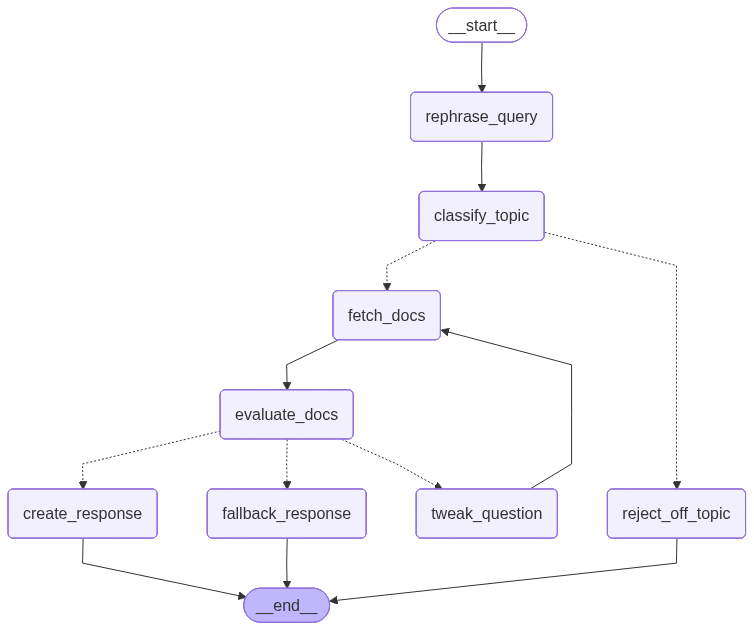

In [10]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

# 实际效果演示
## 场景 1：超范围问题
问个跟餐厅无关的：

In [11]:
input_data = {"question": HumanMessage(content="How is the weather?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})

Entering rephrase_query with state: {'question': HumanMessage(content='How is the weather?', additional_kwargs={}, response_metadata={})}
Entering classify_topic
classify_topic: topic_flag = No
Entering topic_router
Routing to reject_off_topic
Entering reject_off_topic


{'turns': [HumanMessage(content='How is the weather?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I can't respond to that!", additional_kwargs={}, response_metadata={})],
 'retrieved_docs': [],
 'topic_flag': 'No',
 'refined_query': 'How is the weather?',
 'ready_for_response': False,
 'refinement_attempts': 0,
 'question': HumanMessage(content='How is the weather?', additional_kwargs={}, response_metadata={})}

系统识别出这是超范围问题，直接拒绝了。
## 场景 2：找不到答案的问题
问个文档里没有的信息：

In [12]:
input_data = {"question": HumanMessage(content="How old is the owner of the restaurant Bella Vista?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 2}})

Entering rephrase_query with state: {'question': HumanMessage(content='How old is the owner of the restaurant Bella Vista?', additional_kwargs={}, response_metadata={})}
Entering classify_topic
classify_topic: topic_flag = Yes
Entering topic_router
Routing to fetch_docs
Entering fetch_docs
fetch_docs: Retrieved 2 documents
Entering evaluate_docs
Evaluating doc: Bella Vista is owned by Antoni... Result: No
Evaluating doc: Bella Vista is open from Monda... Result: No
evaluate_docs: ready_for_response = False
Entering decision_router
Routing to tweak_question
Entering tweak_question
tweak_question: Refined to: Refined question: What is the age of the person who owns the Bella Vista restaurant?
Entering fetch_docs
fetch_docs: Retrieved 2 documents
Entering evaluate_docs
Evaluating doc: Bella Vista is owned by Antoni... Result: No
Evaluating doc: Bella Vista offers a variety o... Result: No
evaluate_docs: ready_for_response = False
Entering decision_router
Routing to tweak_question
Entering

{'turns': [HumanMessage(content='How old is the owner of the restaurant Bella Vista?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm sorry, but I couldn't find the information you're looking for.", additional_kwargs={}, response_metadata={})],
 'retrieved_docs': [],
 'topic_flag': 'Yes',
 'refined_query': 'Refined question: How old is the owner of the Bella Vista restaurant?',
 'ready_for_response': False,
 'refinement_attempts': 2,
 'question': HumanMessage(content='How old is the owner of the restaurant Bella Vista?', additional_kwargs={}, response_metadata={})}

问题本身属于可回答范围，但检索到的文档都不相关。系统尝试改写问题重新检索了两次，最后诚实地承认找不到答案。
## 场景 3：正常对话加追问
先问营业时间，再追问周日的情况：

In [13]:
graph.invoke(input={"question": HumanMessage(content="When does Bella Vista open?")}, config={"configurable": {"thread_id": 3}})
graph.invoke(input={"question": HumanMessage(content="Also on Sunday?")}, config={"configurable": {"thread_id": 3}})

Entering rephrase_query with state: {'question': HumanMessage(content='When does Bella Vista open?', additional_kwargs={}, response_metadata={})}
Entering classify_topic
classify_topic: topic_flag = Yes
Entering topic_router
Routing to fetch_docs
Entering fetch_docs
fetch_docs: Retrieved 2 documents
Entering evaluate_docs
Evaluating doc: Bella Vista is open from Monda... Result: Yes
Evaluating doc: Bella Vista offers a variety o... Result: No
evaluate_docs: ready_for_response = True
Entering decision_router
Routing to create_response
Entering create_response
create_response: Answer generated: Bella Vista opens at 11:00 AM every day of the week.
Entering rephrase_query with state: {'turns': [HumanMessage(content='When does Bella Vista open?', additional_kwargs={}, response_metadata={}), AIMessage(content='Bella Vista opens at 11:00 AM every day of the week.', additional_kwargs={}, response_metadata={})], 'retrieved_docs': [Document(metadata={'source': 'restaurant_info.txt'}, page_conten

{'turns': [HumanMessage(content='When does Bella Vista open?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Bella Vista opens at 11:00 AM every day of the week.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Also on Sunday?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Yes, Bella Vista is open at 11:00 AM on Sundays.', additional_kwargs={}, response_metadata={})],
 'retrieved_docs': [Document(metadata={'source': 'restaurant_info.txt'}, page_content='Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 AM to 10:00 PM, while weekend hours are extended from 11:00 AM to 11:00 PM.')],
 'topic_flag': 'Yes',
 'refined_query': 'Is Bella Vista open at 11:00 AM on Sundays as well?',
 'ready_for_response': True,
 'refinement_attempts': 0,
 'question': HumanMessage(content='Also on Sunday?', additional_kwargs={}, response_metadata={})}

系统利用对话历史正确理解了"Also on Sunday?"这个追问，把它改写成完整问题后成功检索并回答。

到这里就完成了一个具备自适应能力的 RAG 系统，不只是做简单的相似度搜索。

# 总结
LangGraph 的图架构让这类系统的开发和迭代变得相对简单，可以方便地加入新节点、接入外部 API，或者连接到其他 agent 形成更复杂的工作流。

但是还应该注意一下问题，检索质量本质上还是受 embedding 效果制约，改写查询能缓解但解决不了根本问题。每次用 LLM 给文档打分会增加响应延迟和调用成本，文档多了开销就很明显。重试次数现在写死的，实际使用可能需要根据场景动态调整。

当前只保留会话内的记忆，真正的长期记忆（比如结合向量库和关系数据库）需要额外设计。分类器的判断逻辑是硬编码在 prompt 里的，扩展到新领域得改提示词或者训练专门的分类器。